In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Peak Integration

A major branch of analytical chemistry deals with separations. As the name implies, a separation will separate different molecules from each other so that the individual components of a mixture can be analyzed quantiatively. For example, in capillary electrophoresis where molecules move through a narrow tube at different speeds due to differences in the size and charge. A detector is placed near the end the separation distance (in capillary electrophoresis this is often near the end of the tube or capillary). As molecules pass the detector, the signal from the detector rises creating a peak.  Calculating the area of the peak is a common task for separation scientists who want to measure how much of the molecule or compound is present.

Below we are going to integrate a peak for separation using capillary electrophoresis. The data file we are analyzing measures the signal from a fluoresenct molecule called fluorescein.


In [150]:
# Read in the File
data_file = r".\files\sipm_detector.xlsx"
data = pd.read_excel(data_file)
data.head()

,Time,28.6,28.6.1,28.6.2,28.6.3,28.6.4,28.6.5,29.7,29.7.1,29.7.2,...,27.7.2,27.7.3,27.7.4,27.7.5,26.6,26.6.1,26.6.2,26.6.3,26.6.4,26.6.5
0,0.000,0.012884,0.012854,0.012939,0.012899,0.012888,0.012963,0.025099,0.025152,0.025175,...,0.007780,0.007687,0.007729,0.007769,0.003378,0.003358,0.003337,0.003326,0.003329,0.003342
1,0.125,0.013135,0.013135,0.013183,0.013161,0.013092,0.013219,0.025398,0.025376,0.025375,...,0.008014,0.007922,0.007950,0.008026,0.003591,0.003636,0.003596,0.003608,0.003601,0.003614
2,0.250,0.012960,0.012954,0.013066,0.013012,0.012965,0.013084,0.025264,0.025226,0.025270,...,0.007872,0.007787,0.007851,0.007846,0.003462,0.003448,0.003433,0.003415,0.003432,0.003445
3,0.375,0.012948,0.012922,0.012955,0.013018,0.012982,0.013019,0.025202,0.025176,0.025252,...,0.007801,0.007753,0.007764,0.007761,0.003415,0.003385,0.003394,0.003362,0.003395,0.003401
4,0.500,0.012943,0.012954,0.012987,0.013021,0.013018,0.013041,0.025252,0.025269,0.025236,...,0.007802,0.007781,0.007784,0.007809,0.003403,0.003397,0.003425,0.003404,0.003413,0.003415


The file includes a single time column followed by a series of columns corresponding to different separations. These separations were used to study the detection limits of a new detector. The header of the file gives the different voltage settings used by the detector (where an increased voltage results in an increased signal). For our purposes we are only going to look at a single separation (28.6 V). 

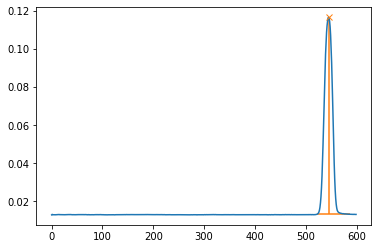

In [154]:
## From the Scipy Documentation for find_peaks

x = data[28.6].values
plt.plot(x)

Now that we have our data read into our Pandas dataframe, we need to find the portion of the separation that includes just the peak. We will use a function provided by Scipy module called 'find_peaks' to locate the peak. Check out the documentation for find_peaks for more information on how this works

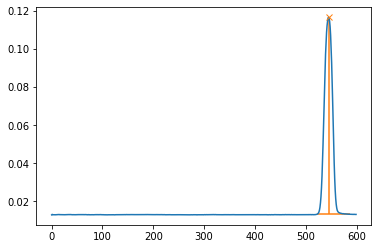

In [156]:
peaks, properties = find_peaks(x, prominence=0.02, width=5, threshold=0.0001, rel_height=0.999)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.vlines(x=peaks, ymin=x[peaks] - properties["prominences"],
           ymax = x[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")
plt.show()

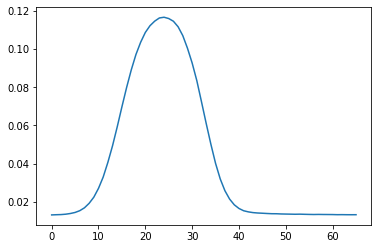

In [157]:
# Extract Just the Peak
stop = int(properties['right_ips'])
start = int(properties['left_ips'])
plt.plot(x[start:stop+1])

Calculating the area of this peak used to be a nontrivial task. Before computers were commonplace, scientists would take the recording of the detector and copy it to a paper with a known thickness and density. They would cut out the peak and measure the weight on the scale, and calculate the area using the weight and density of the paper. This would leave room for error due to the accuracy of the scissor work from the scientist (imagine the difficulty of cutting small peaks!!)

Luckily, with computers it is quite easy to get a very accurate estimation of the peak. The most common is to use a trapezoidal integration. Here, a straight line is drawn between the points and the area of the trapezoid formed is summed together with all the other trapezoid areas along the timeseries to calculate the peak area. 

In [160]:
# Integrate using Trapezoidal Approximation
peak_signal = x[start:stop+1]
peak_time = data["Time"].values[start:stop+1]


area = np.trapz(peak_signal, peak_time)
print(f"Trapezoidal Area is : {area:.4f}")

Trapezoidal Area is : 0.3454


# Estimating Peak Area using Monte Carlo

Similar to calculating PI using montecarlo (see buffon's needle experiment as an example), we can approximate the total area under the by randomly distributing many points across a square area. We count the points that fall under the curve by the total number of points and multiply that by the area of the entire square. 

This was first published in Chromatographia in 1974. In this paper, the authors copy random coordinates to a glass plate and overlay that plate over the separation trace. They then count the number of points found between the baseline and the curve ($x_i$). They calculate the area according to the following equation:

$ A_{peak} = \frac{ x_i }{ x_{total}} A_{slide} $ 

where $A_{slide}$ is the total area of the glass slide and $x_{total}$ is the total number of points on the glass slide. They would then repeat the Monte Carlo experiment by rotating the glass slide 90 degrees and recounting. 

They could increase the accuracy of smaller peaks by increasing the density of the points (done by increasing the points and decreasing the slide area). 

With a computer we can mimic this experiment quite easily. We will use a random number generator to generate the coordinates across a known area. Using a spline we can interpolate what the signal or y-value would be for any time or x-coordinate generated by the number generator.

*S. Turina, L. Klasinc, V. Jamnicki "Area Determination Under Chromatographic Curves Using the Monte Carlo Method" Chromatographia, Vo. 7, No. 4, April 1974*

In [161]:
from scipy.interpolate import interp1d # our interpolation function
import random

class TurinaArea:
    """
    Monte carlo based peak integrator where random points are generated and the fraction of points that fall under the curve
    is multipled by the area of the 'glass slide' or bounds of the x and y arrays. 
    """
    
    def __init__(self, y, x, min_y=None, max_y=None):
        """
        :param y: array of signal values, length must be equal to x
        :param x: array of time values, length must be equal to y
        :param min_y: mimimum signal for the number generator, if None min_y will be the minumum value of the y array
        :param max_y: maximum signal for the number generator, if None max_y will be the maximum value of the y array
        """
        # Simulation Paramters
        assert (len(y)==len(x)), "Length of input x and y must be equal"
        self.y = y
        self.x = x
        self.spline = interp1d(x, y, kind='cubic')
        if max_y is None:
            self.max_y = max(self.y)
        if min_y is None:
            self.min_y = min(self.y)
        self.min_y = min_y
        self.min_x = min(x)
        self.max_x = max(x)
        self.area = (self.max_y-self.min_y)*(self.max_x-self.min_x)

        
        # Counters
        self.enclosed_points = 0
        self.total_points = 0
        
        # Arrays to keep track of points and histories for plotting purposes
        self.history = []
        self.x_history = []
        self.y_history = []
    
    def reset(self):
        """
        Resets the counters and histories before the start of a simulation
        """
        self.enclosed_points = 0
        self.total_points =0
        self.history = []
        self.x_history = []
        self.y_history = []
        
    def step(self, history=True):
        """
        Logic to be applied for each random toss, or x,y coordinate generated. 
        
        Intervals for x and y are dictated by the min_x, min_y, max_x, max_y fields. A interp1d function is used to interpolate
        the height of the curve for any given x generated. If the random value y is smaller than the interoplated signal, the 
        point is considered under the curve and is added to the tally. 
        
        :param history: Boolean, when True record the point coordinates and peak area for plotting purposes
        """
        point_x = random.uniform(self.min_x, self.max_x)
        point_y = random.uniform(self.min_y, self.max_y)
        
        if point_y < self.spline(point_x):
            self.enclosed_points +=1
        
        self.total_points +=1
        
        if history:
            self.history.append(self.enclosed_points/self.total_points*self.area)
            self.x_history.append(point_x)
            self.y_history.append(point_y)
        
    def simulate(self, tosses=100, history=False):
        """
        :param tosses: how many points to generate
        :param history: Booelan, when True the history of the point coordinates and peak area will be recorded
        """
        
        for i in range(tosses):
            self.step(history)
        return self.enclosed_points/self.total_points*self.area
    
        
        

In [168]:
turina = TurinaArea(peak_signal, peak_time)
turina_area = turina.simulate(tosses=500, history=True)
print(f"Approximate area from simulation: {turina_area:.4f}")

Approximate area from simulation: 0.3752


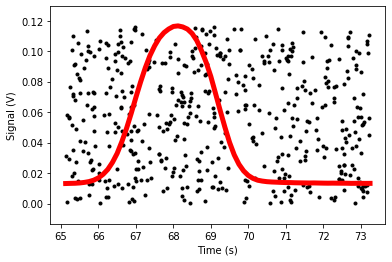

In [169]:
# Plot the points used during the experiment with the peak curve overlayed

fig, ax = plt.subplots()
ax.set_ylabel('Signal (V)')
ax.set_xlabel('Time (s)')

ax.scatter(turina.x_history, turina.y_history, marker= ".", color='k')
ax.plot(peak_time, peak_signal, linewidth=5, color='r')

pass

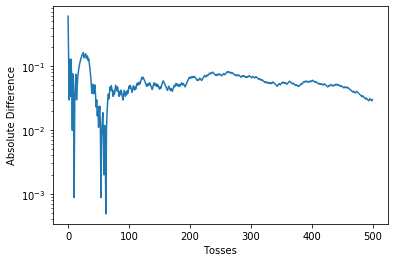

In [170]:
# Plot the difference between the TrapZ and the MC estimation as a function of tosses

fig, ax = plt.subplots()
ax.set_ylabel('Absolute Difference')
ax.set_yscale('log')
ax.set_xlabel('Tosses')
plt.plot(np.abs(np.subtract(area,turina.history)))

In the Turino paper they repeated the experiment four times by rotating the glass slide 90 degrees. For our experiment we can quite easily run this experiment hundreds or thousands of times. 

Lets use a simple MonteCarlo class that will call our Turino Simulation and record the results. We will take the median of the results as our expected peak area. 

In [171]:
class MonteCarlo:
    """
    We will try to use this monte carlo class for many of our simulations. It will restore a list of outcomes as a 
    field titled "results". 
    
    Later we will update this to include the multiprocessing module to run our simulations faster.
    """
    
    def __init__(self):
        self.results = []
    
    def run(self,simulation_object, number_of_simulations, *args, **kwargs):
        """
        Pass a simulation object (our Plink Class for example), the number of times to run the MC simulation, and any arguments 
        keyword arguments that are necessary for the simulate command of the simulation object
        
        """
        
        self.results = [simulation_object.simulate(*args,**kwargs) for i in range(number_of_simulations)]
        
            

Mean Area: 0.3450 +/- 0.0076
Error is : -0.0004


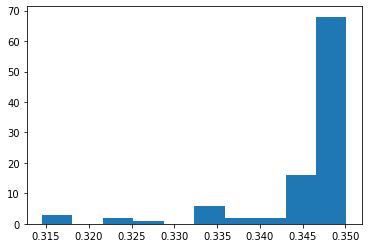

In [174]:
turina = TurinaArea(peak_signal, peak_time)
mc = MonteCarlo()
mc.run(turina, number_of_simulations=100, tosses=200)

fig, ax = plt.subplots()
ax.hist(mc.results)
print(f"Mean Area: {np.mean(mc.results):.4f} +/- {np.std(mc.results):.4f}")
print(f"Error is : {np.mean(mc.results)-area :.4f}")

From our monte carlo simulation we see that we get a very comoparable area as that given by the trapezoidal approximation. Increasing the number of experiments or number of tosses will decrease the standard deviation of area. It is important to note, that the standard deviation could not be used in place of the standard deviation you get from technical replicates. It is valuable for us as a metric to determine if we need to increase the number of simulations. 